# Hello CNN Xception Style Dogs vs. Cats Classifier

Build an Xception architecture style Dogs vs. Cats classifier using a small dataset from Kaggle.  Should work better than a vanilla Sequential CNN.

In [1]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers

2025-03-24 19:19:22.310092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742869162.327887   19652 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742869162.333310   19652 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742869162.347259   19652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742869162.347278   19652 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742869162.347280   19652 computation_placer.cc:177] computation placer alr

### Download Data from Kaggle

https://www.kaggle.com/c/dogs-vs-cats/data

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). For this example create a new dataset with three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class.

In [2]:
import os, shutil, pathlib
from sys import platform

# Point this to where the training data from Kaggle was downloaded and extracted
if platform=="linux": 
    download_dir = pathlib.Path("../../Datasets/Kaggle_dogs_vs_cats/train")
elif platform == "win32": 
    download_dir = pathlib.Path("/Datasets/Kaggle_dogs_vs_cats/train")
elif platform == "darwin":
    print("Specify file pathf or MacOS")
    raise Exception("Attendion needed")
else:
    raise Exception("Unknown Platform")


# Create small dataset under the project directory
small_data_dir = pathlib.Path("data/dogs_vs_cats_small")

def make_subset(subset_name, start_idx, end_idx):
    for category in ("cat", "dog"):
        dir = small_data_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_idx, end_idx)]
        for fname in fnames:
            shutil.copyfile(src=download_dir / fname, dst=dir / fname)

make_subset("train", start_idx=0, end_idx=1000)
make_subset("validation", start_idx=1000, end_idx=1500)
make_subset("test", start_idx=1500, end_idx=2500)

### Data Preprocessing

- Read the picture files.
- Decode the JPEG content to RGB grids of pixels
- Convert pixel grids into floating-point tensors.
- Resize them to 180x180 size
- Pack them into batches of 32 images

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    small_data_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_ds = image_dataset_from_directory(
    small_data_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_ds = image_dataset_from_directory(
    small_data_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.


I0000 00:00:1742869170.856766   19652 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9147 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:04:00.0, compute capability: 7.0


Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
# Check that data shapes are correct
for data_batch, labels_batch in train_ds:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### Build the CNN

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [6]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)  # Scale to range [0, 1]
# Convolution Layers
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)

    x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
# Fully Connected Layer 
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 176,  │      2,400 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 176,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 176, 176,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 176, 176,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 88, 88,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 88, 88,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

### Compile model  

In [8]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Build the model

In [10]:
history = model.fit(train_ds, epochs=60, validation_data=validation_ds)

Epoch 1/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6209 - loss: 0.6553 - val_accuracy: 0.5050 - val_loss: 0.6922
Epoch 2/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.6324 - loss: 0.6496 - val_accuracy: 0.5000 - val_loss: 0.6987
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.6499 - loss: 0.6244 - val_accuracy: 0.5000 - val_loss: 0.7000
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.6911 - loss: 0.6090 - val_accuracy: 0.5000 - val_loss: 0.7835
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.6758 - loss: 0.6200 - val_accuracy: 0.5360 - val_loss: 0.7086
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.6898 - loss: 0.5854 - val_accuracy: 0.5660 - val_loss: 0.6999
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6887 - loss: 0.5992 - val_accuracy: 0.5960 - val_loss: 0.6744
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7211 - loss: 0.5605 - val_accuracy: 0.5

### Plot Training and Validation Accuracy

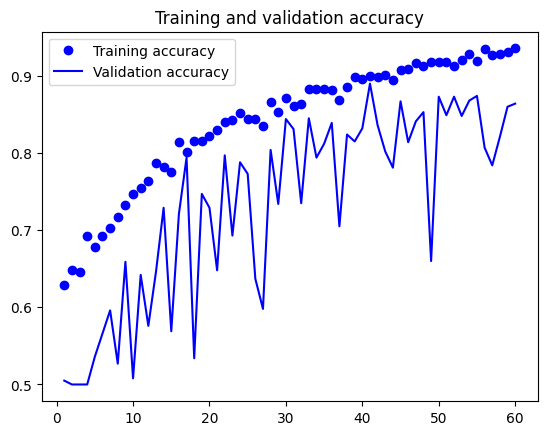

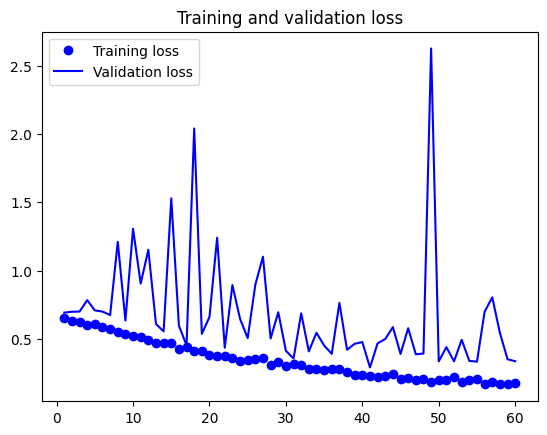

In [11]:
accy = history.history["accuracy"]
val_accy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accy) + 1)
plt.plot(epochs, accy, "bo", label="Training accuracy")
plt.plot(epochs, val_accy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
model.save("dogs_vs_cats.keras")

### Evaluate with test set

In [13]:

test_model = keras.models.load_model("dogs_vs_cats.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8654 - loss: 0.4030
Test accuracy: 0.868


Better than Vanilla CNN in ```hello_CNN_dogs_vs_cats_classifier.ipynb```